In [1]:
# set the backend
import matplotlib
matplotlib.use('nbagg') # set plotting backend
import matplotlib.pyplot as plt
plt.ion()

# standard packages
import numpy as np
import pandas as pd
import interpretable as inter
import typing

# included noise generator
from colorednoise import powerlaw_psd_gaussian

from sklearn.linear_model import LinearRegression
from FBM import FBM


$\underline{\text{Power-law correlated process generation:}}$

In [2]:
# autocorrelation exponents
gamma_s = 0.5   # ... of the signs
# time steps to simulate
steps = 10**6 
max_lag = 1000

In [3]:
# signs
s = np.sign(powerlaw_psd_gaussian(1-gamma_s, steps)).astype(int)

In [4]:
# power law autocovariance decay: 

#f = FBM(n = steps, hurst = 0.75, length = 1, method = 'daviesharte')
#s = f.fgn()
#s /= s.std() # we normalize the dat (to work with unitary variance data)

$\underline{\text{Returns generation:}}$

In [5]:
# simulate TIM1 model as "ground truth"
# ---------------------------------------------
true_kernel = pd.concat((pd.Series([0]), pd.Series(np.exp(-.005*np.arange(1,steps+1)))))
r = inter.generator(orderflow = s, kernel = true_kernel, noise = np.zeros(steps), max_lag = max_lag)


$\text{Create a dataframe that resembles the way actual trading data may be analysed:}$

In [6]:
# simulate split over different days
mean_day_length = 2**8
trades = pd.DataFrame({
    'r':         r,  # one-step mid-return
    'sign':       s,  # sign of a single trade (buy: 1, sell: -1) 
})

In [7]:
trades.head()

r  sign
0 -0.995012    -1
1 -0.990050    -1
2 -0.985112    -1
3  1.009826     1
4 -0.985235    -1

$\underline{\text{Stylized facts:}}$

In [8]:
def compute_R(mid, sign, taus):
    def c_group(T):
        return ((mid.shift(-T)-mid)*sign).mean()
    c_g = np.vectorize(c_group)
    return c_g(taus)

In [9]:
Res = inter.response_function(s, r.cumsum(), max_lag+1)
Res2 = compute_R(r.cumsum(), s, np.arange(max_lag+1))

<IPython.core.display.Javascript object>


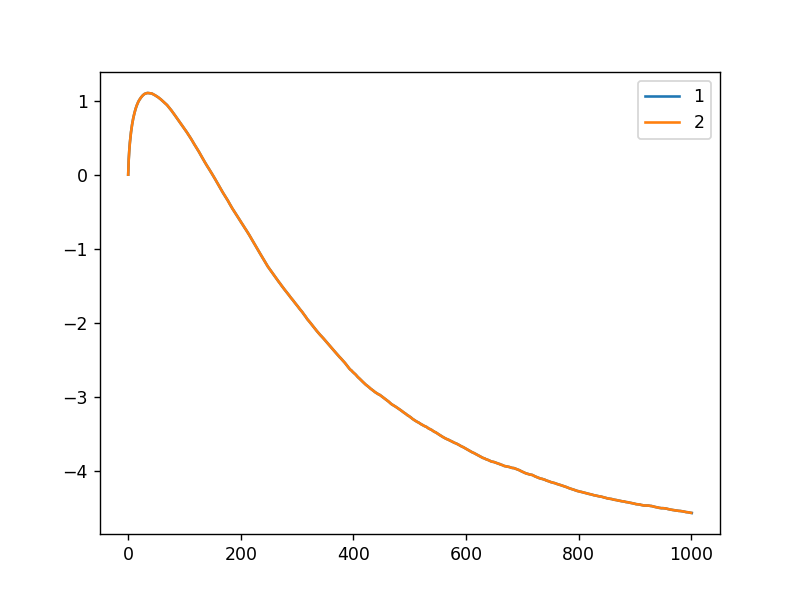

In [10]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
plt.plot(Res, label = '1')
plt.plot(Res2, label = '2')
plt.legend()

In [11]:
def correlation(x, y, taus):
    """Inputs :
    x: pd.Series
    y: pd.Series
    taus: array of integers
    Returns:
    A numpy array containing the correlation function as the average x(t)*y(t+tau)
    for each value of tau in taus"""
    def c_group(T):
        return (x*y.shift(-T)).mean()
    c_g = np.vectorize(c_group)
    return c_g(taus)

In [12]:
Acf2 = correlation(pd.Series(s), pd.Series(s), np.arange(max_lag))
Acf = inter.autocovariance(s, max_lag)

In [34]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
plt.plot(Acf, label = '1')
plt.plot(Acf2, label = '2')
#plt.xlim((.00,1000))
#plt.ylim((.0,.005))
plt.legend()

<IPython.core.display.Javascript object>

In [14]:
def Variogram(x, taus):
    """Inputs:
    x: pd.Series
    taus: array of integers
    Returns:
    A numpy array containing the variogram of x evaluated at each value of tau in taus"""
    def vgram(T):
        return (x - x.shift(T)).var()
    vgram = np.vectorize(vgram)
    return vgram(taus)

In [15]:
Vario = Variogram(r.cumsum(), np.arange(max_lag+1))
Vario2 = inter.variogram(r.cumsum(), max_lag+1)

In [16]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
plt.plot(Vario[1:]/np.arange(1,1001), label = 'real data')
plt.plot(Vario2[1:]/np.arange(1,1001), label = 'real data')
#plt.xlim((.00,1000))
#plt.ylim((.0,.005))
plt.legend()

<IPython.core.display.Javascript object>

In [17]:
pd.Series(Vario)

0          0.000000
1          0.967160
2          2.359321
3          4.003436
4          5.851410
           ...     
996     1697.085637
997     1697.350369
998     1697.613609
999     1697.875222
1000    1698.134327
Length: 1001, dtype: float64

In [18]:
pd.Series(Vario2)

0          0.000000
1          0.967159
2          2.359319
3          4.003432
4          5.851404
           ...     
996     1697.083939
997     1697.348671
998     1697.611911
999     1697.873524
1000    1698.132629
Length: 1001, dtype: float64

$\underline{\text{Model calibration:}}$

In [19]:
L = 300
A = inter.regression_matrix(s, L)
Y = r[L:]
reg = LinearRegression().fit(A, Y)

K_star = reg.coef_
K_star = pd.Series(K_star)
G_star = pd.concat((pd.Series([0]), K_star.cumsum()))

# problem inversion
S_PI = inter.sign_return_correlation2(r, s, len(Res))
K_PI = inter.problem_inversion(S_PI, np.linalg.inv(inter.covariance_matrix(Acf, L)), L)
G_PI = pd.concat((pd.Series([0]), K_PI.cumsum()))

In [20]:
trades['r_PI'] = inter.generator(orderflow = s, kernel = G_PI, noise = np.zeros(steps), max_lag = L)
trades['r_star'] = inter.generator(orderflow = s, kernel = G_star, noise = np.zeros(steps), max_lag = L)

In [21]:
L = 300

taus = np.arange(0,301,dtype  ='int')
c = correlation(pd.Series(s), pd.Series(s), taus)

# problem inversion
S_PI2 = correlation(s, r, taus)
K_PI2 = inter.problem_inversion(S_PI2, np.linalg.inv(inter.covariance_matrix(Acf, L)), L)
G_PI2 = pd.concat((pd.Series([0]), K_PI.cumsum()))

In [22]:
N = 301
A2 = np.zeros((N,N))
C = c
for l in range(N):
    for n in range (N):
        A2[l,n] = C[np.abs(n-l)]
        
A_inv = np.linalg.inv(A2)
G_dot = np.matmul(A_inv,S_PI2)
G = pd.Series(np.cumsum(G_dot))
G = pd.concat((pd.Series([0]), G))

In [23]:
res_PI = inter.generator(orderflow = s, kernel = G_PI, noise = np.zeros(steps), max_lag = L)[L:]
res_star = pd.Series(reg.predict(A))
res_PI2 = inter.generator(orderflow = s, kernel = G, noise = np.zeros(steps), max_lag = L)[L:]

In [24]:
res_PI.head()

300   -0.820408
301   -0.818996
302   -0.818044
303    1.171130
304    1.168324
dtype: float64

In [25]:
res_star.head()

0   -0.820340
1   -0.818928
2   -0.817977
3    1.171197
4    1.168392
dtype: float64

In [26]:
res_PI2.head()

300   -0.820408
301   -0.818998
302   -0.818048
303    1.171127
304    1.168324
dtype: float64

<IPython.core.display.Javascript object>


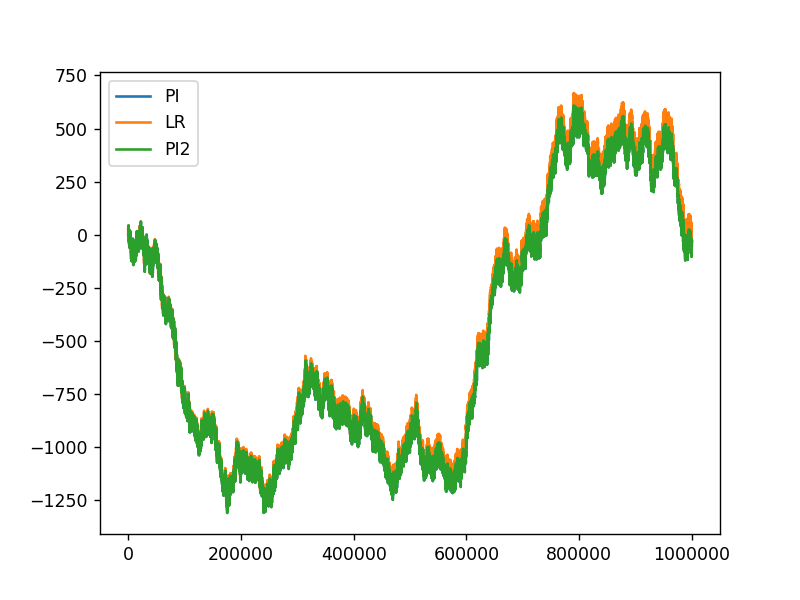

In [27]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
plt.plot(res_PI.cumsum(), label = 'PI')
plt.plot(res_star.cumsum(), label = 'LR')
plt.plot(res_PI2.cumsum(), label = 'PI2')

plt.legend()

In [28]:
trades['r_PI'] = inter.generator(orderflow = s, kernel = G_PI, noise = np.zeros(steps), max_lag = L)
trades['r_PI2'] = inter.generator(orderflow = s, kernel = G, noise = np.zeros(steps), max_lag = L)
trades['r_star'] = inter.generator(orderflow = s, kernel = G_star, noise = np.zeros(steps), max_lag = L)

$\underline{\text{Plot the results:}}$

<IPython.core.display.Javascript object>


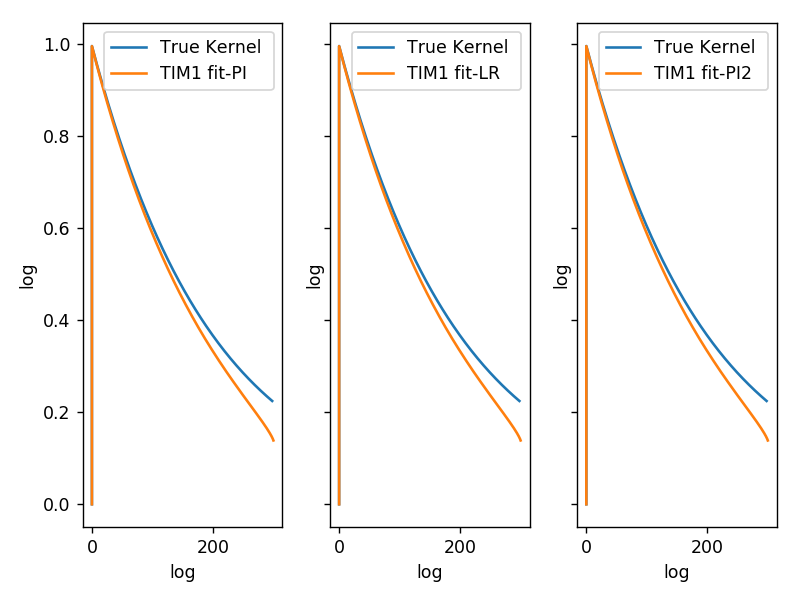

In [29]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)

sample = 1 # choose of the keys listed above

ax[0].plot(true_kernel[:300], label='True Kernel ')
ax[0].plot(G_PI, label='TIM1 fit-PI')
ax[0].legend()
ax[0].set_xlabel('log')
ax[0].set_ylabel('log')


ax[1].plot(true_kernel[:300], label='True Kernel ')
ax[1].plot(G_star, label='TIM1 fit-LR')
ax[1].legend()
ax[1].set_xlabel('log')
ax[1].set_ylabel('log')

ax[2].plot(true_kernel[:300], label='True Kernel ')
ax[2].plot(G, label='TIM1 fit-PI2')
ax[2].legend()
ax[2].set_xlabel('log')
ax[2].set_ylabel('log')

plt.tight_layout()

In [35]:
plt.figure(2, figsize=(8,4))
ax = plt.gca()

# choose a range between 0 and steps for the plot.
plot_start = 0
plot_end   = 1000
# plot the following predicted returns from these fitted models
# (un)comment lines to (de)select models
plot_models = [
    'r_star',
    'r_PI',
    'r_PI2'
]


# plot diverse models
rename_models = {
    i : i.upper().replace('R_','').replace('_X2','* (approx.)')
    for i in plot_models
}
styles = ['--','-','-.']
predicted_returns = (
    trades.iloc[plot_start:plot_end][plot_models]
    .rename(columns=rename_models)
)
predicted_returns.plot(style=styles,ax=ax)

# original returns
original_returns = trades['r']
original_returns.columns = ['Original']
original_returns.plot(style='k--', ax=ax, )


# format
ax.set_xlabel('Time step')
ax.set_xlim((0,100))
ax.set_ylabel('Return')
plt.tight_layout()

<IPython.core.display.Javascript object>

In [31]:
trades

r  sign      r_PI    r_star     r_PI2
0      -0.995012    -1 -0.994697 -0.994697 -0.994699
1      -0.990050    -1 -0.989482 -0.989482 -0.989485
2      -0.985112    -1 -0.984314 -0.984314 -0.984317
3       1.009826     1  1.010210  1.010209  1.010208
4      -0.985235    -1 -0.984517 -0.984518 -0.984521
...          ...   ...       ...       ...       ...
999995 -1.079864    -1 -1.080135 -1.080121 -1.080123
999996  0.915580     1  0.911681  0.911696  0.911693
999997 -1.078978    -1 -1.077592 -1.077577 -1.077580
999998 -1.073563    -1 -1.074008 -1.073994 -1.073998
999999 -1.068242    -1 -1.070474 -1.070460 -1.070466

[1000000 rows x 5 columns]

In [32]:
vario_PI = inter.variogram(trades.r_PI.cumsum(), max_lag+1)
vario_PI2 = inter.variogram(trades.r_PI2.cumsum(), max_lag+1)
vario_star = inter.variogram(trades.r_star.cumsum(), max_lag+1)

In [33]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

plt.plot(vario_PI[1:]/np.arange(1,len(Vario2)), label = 'PI synthetic data')
plt.plot(vario_PI2[1:]/np.arange(1,len(Vario2)), label = 'PI2 synthetic data')
plt.plot(vario_star[1:]/np.arange(1,len(Vario2)), label = 'LR synthetic data')
plt.plot(Vario2[1:]/np.arange(1,len(Vario2)), label = 'real data')
#plt.xlim((.00,1000))
#plt.ylim((.0,.005))
plt.legend()

<IPython.core.display.Javascript object>